# Kaggle competition

Предсказание рейтинга шоколада.

https://www.kaggle.com/competitions/practical-ml-chocolate/overview

*Я на Kaggle: WhyAyeMan (https://www.kaggle.com/whyayeman)*

# 1. Понимание бизнеса

## 1.1. Цель

Целью настоящей работы является предсказание рейтинга качества шоколада по его характеристикам.

## 1.2. Описание

В датасете содержится информация о более чем 1700 шоколадках. Представлена информация о темном шоколаде:
- Company - фабрика-производитель
- Specific Bean Origin - географический регион происхождения
- REF - параметр, определяющий момент внесения записи в базу данных (чем выше значение, тем "свежее" запись)
- Review - дата публикации отзыва
- Cocoa Percent - процентное содержание какао
- Company Location - страна производитель
- Rating - экспертный рейтинг (целевой признак)
- Bean Type - используемый сорт какао-бобов, если таковой имеется
- Broad Bean Origin - географический регион происхождения какао-бобов
- quality (оценка качества вина - целевая переменная)

Система рейтинга шоколада:
5 = Elite
4 = Premium
3 = Satisfactory(3.0) to praiseworthy(3.75)
2 = Disappointing
1 = Unpleasant

Задача - по характеристикам шоколадки научиться предсказывать ее рейтинг (без округлений)

# 2. Data understanding

## 2.1. Import libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
!pip install association_metrics -q
import association_metrics as am
!pip install category_encoders -q
from category_encoders.target_encoder import TargetEncoder
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
!pip install catboost -q
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
!pip3 install optuna -q
import optuna
import warnings
warnings.filterwarnings("ignore")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.8 MB/s eta 0:00:00


## 2.2. Загрузка данных

In [2]:
TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"

In [3]:
data = pd.read_csv(TRAIN)
data.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   REF                   1255 non-null   int64  
 3   Review                1255 non-null   int64  
 4   Cocoa Percent         1255 non-null   object 
 5   Company Location      1255 non-null   object 
 6   Rating                1255 non-null   float64
 7   Bean Type             1254 non-null   object 
 8   Broad Bean Origin     1254 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 88.4+ KB


## 2.3. Статистика и визуализации

In [5]:
# проверка на наличие повторяющихся записей
data.duplicated().value_counts()

False    1255
dtype: int64

In [6]:
# основные статистики числовых признаков
data.describe()

,REF,Review,Rating
count,1255.000000,1255.000000,1255.000000
mean,1045.152191,2012.382470,3.176494
std,551.284249,2.922499,0.478948
min,5.000000,2006.000000,1.000000
25%,593.000000,2010.000000,2.750000
50%,1077.000000,2013.000000,3.250000
75%,1514.000000,2015.000000,3.500000
max,1952.000000,2017.000000,5.000000


In [7]:
data[['REF', 'Review', 'Rating']].isnull().sum()

REF       0
Review    0
Rating    0
dtype: int64

Пропуски в числовых признаках отсутствуют

In [8]:
# также есть признак "Cocoa Percent", который по факту является числовым
data['Cocoa Percent'].value_counts()

70%      461
75%      166
72%      130
80%       55
65%       49
74%       33
60%       33
68%       32
85%       27
77%       24
64%       24
73%       24
71%       22
76%       17
66%       17
67%       16
100%      14
78%       13
82%       12
55%       12
62%       11
63%        9
90%        8
61%        7
88%        6
58%        6
69%        6
81%        3
83%        3
72.5%      2
84%        2
91%        2
73.5%      2
50%        1
56%        1
53%        1
99%        1
86%        1
46%        1
87%        1
Name: Cocoa Percent, dtype: int64

In [9]:
# преобразуем его к числовому формату
data['Cocoa Percent'] = data['Cocoa Percent'].apply(lambda x: float(x[:-1]))
data['Cocoa Percent'].value_counts().head()

70.0    461
75.0    166
72.0    130
80.0     55
65.0     49
Name: Cocoa Percent, dtype: int64

In [10]:
# посмотрим распределение значений этого признака
data.groupby('Cocoa Percent')['REF'].count().reset_index().sort_values(by='Cocoa Percent')

,Cocoa Percent,REF
0,46.0,1
1,50.0,1
2,53.0,1
3,55.0,12
4,56.0,1
5,58.0,6
6,60.0,33
7,61.0,7
8,62.0,11
9,63.0,9


Значения ниже 54 будем далее считать выбросами

In [11]:
# перечень числовых признаков
num_feats = ['REF', 'Review', 'Cocoa Percent', 'Rating']

REF


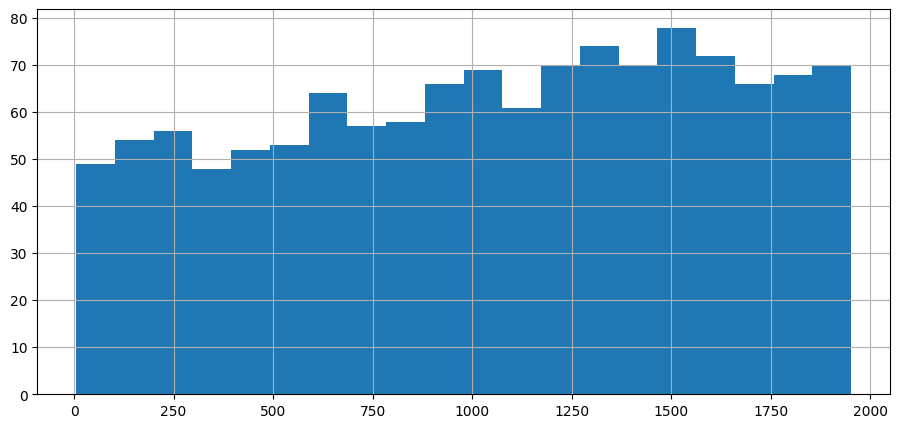


Review


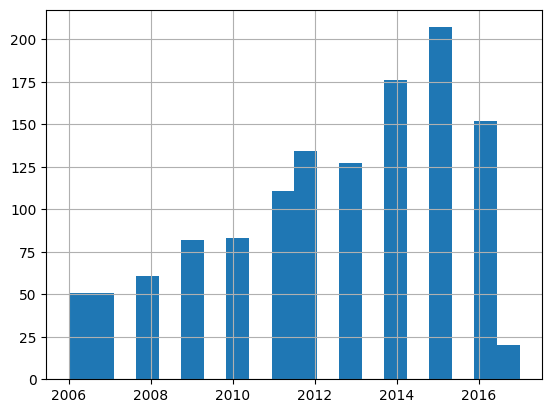


Cocoa Percent


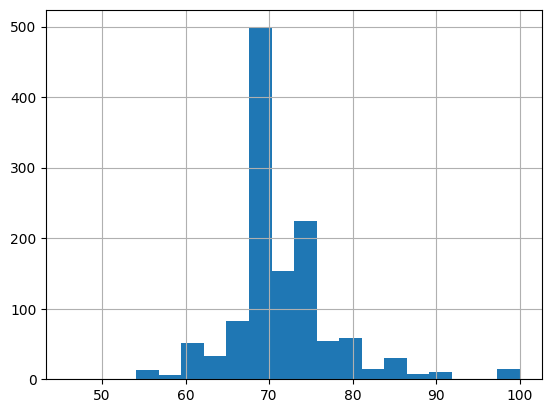


Rating


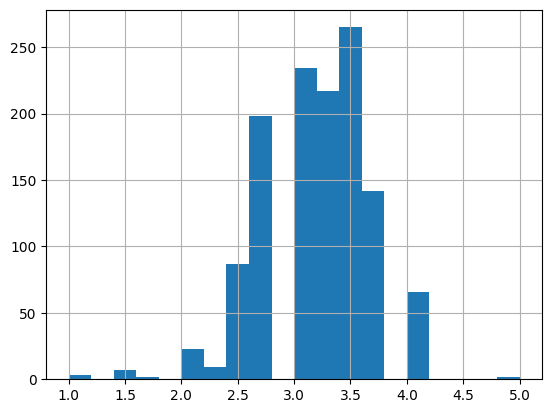

In [12]:
# распределение значений числовых признаков

figure(figsize=(11, 5))

for feat in num_feats:
    print(feat)
    data[feat].hist(bins=20)
    plt.show()
    print()

- Порядковые номера и даты (годы) оставления отзывов распределены в целом равномерно

- Рейтинг (целевой признак) в основном находится в диапазоне от 2.5 до 4 баллов с пиками на 3-3.5 балла. Есть "выбросы" (1-1.75 баллов, 5 баллов)

In [13]:
# удалим выбросы по признаку Cocoa Percent (ниже 54)
data = data[data['Cocoa Percent'] >= 54]

In [14]:
# категориальные переменные
data.describe(include='object')

,Company,Specific Bean Origin,Company Location,Bean Type,Broad Bean Origin
count,1252,1252,1252,1251,1251
unique,376,760,58,38,84
top,Soma,Madagascar,U.S.A.,,Venezuela
freq,35,39,521,627,144


В связи с большим количеством категорий по каждому из категориальных признаков, применение One-hot-encoding невозможно

In [15]:
# перечень категориальных признаков

cat_feats = list(data.columns)

for feat in num_feats:
    cat_feats.remove(feat)

cat_feats

['Company',
 'Specific Bean Origin',
 'Company Location',
 'Bean Type',
 'Broad Bean Origin']

In [16]:
# поиск пропусков в категориальных признаках

data[cat_feats].isnull().sum()

Company                 0
Specific Bean Origin    0
Company Location        0
Bean Type               1
Broad Bean Origin       1
dtype: int64

In [17]:
# пропусков практически нет
# однако есть и неявные пропуски, например:
data['Bean Type'].value_counts()
# таких пропусков по этому признаку очень много - половина записей датасета

                            627
Trinitario                  285
Criollo                     104
Forastero                    53
Forastero (Nacional)         33
Criollo, Trinitario          32
Forastero (Arriba)           32
Blend                        28
Criollo (Porcelana)           9
Forastero (Parazinho)         7
Forastero (Arriba) ASS        6
Trinitario, Criollo           3
Nacional (Arriba)             3
Forastero (Catongo)           2
Criollo, Forastero            2
Criollo (Amarru)              2
Trinitario, Forastero         2
Trinitario (Amelonado)        1
Amazon mix                    1
Trinitario, Nacional          1
Forastero (Amelonado)         1
Criollo (Ocumare 67)          1
Blend-Forastero,Criollo       1
Forastero, Trinitario         1
Criollo (Ocumare 61)          1
Trinitario (85% Criollo)      1
EET                           1
Amazon                        1
Criollo (Wild)                1
Matina                        1
Criollo, +                    1
Criollo 

In [18]:
# посмотрим как выглядит эти пропуски (не отловились функцией isnull)
nnan = data['Bean Type'].mode()[0]
nnan

'\xa0'

In [19]:
# заменяем их на стандартный np.nan
data['Bean Type'] = data['Bean Type'].replace(nnan, np.NaN)
data['Bean Type'].value_counts()

Trinitario                  285
Criollo                     104
Forastero                    53
Forastero (Nacional)         33
Criollo, Trinitario          32
Forastero (Arriba)           32
Blend                        28
Criollo (Porcelana)           9
Forastero (Parazinho)         7
Forastero (Arriba) ASS        6
Trinitario, Criollo           3
Nacional (Arriba)             3
Forastero (Catongo)           2
Criollo, Forastero            2
Criollo (Amarru)              2
Trinitario, Forastero         2
Trinitario (Amelonado)        1
Amazon mix                    1
Trinitario, Nacional          1
Forastero (Amelonado)         1
Criollo (Ocumare 67)          1
Blend-Forastero,Criollo       1
Forastero, Trinitario         1
Criollo (Ocumare 61)          1
Trinitario (85% Criollo)      1
EET                           1
Amazon                        1
Criollo (Wild)                1
Matina                        1
Criollo, +                    1
Criollo (Ocumare)             1
Nacional

In [20]:
# для начала заполним их как "Unknown" (не оптимальное решение из-за высокой доли пропусков):
data['Bean Type'].fillna('Unknown', inplace=True)

In [21]:
# оценка корелляции категориальных столбцов (V-мера Крамера)
XC = data.apply(
    lambda x: x.astype('category') if x.dtype == 'object' else x)

cramersv = am.CramersV(XC)
cramersv.fit()

,Company,Specific Bean Origin,Company Location,Bean Type,Broad Bean Origin
Company,1.000000,0.771031,0.999651,0.615525,0.603567
Specific Bean Origin,0.771031,1.000000,0.808103,0.907905,0.983537
Company Location,0.999651,0.808103,1.000000,0.289691,0.381826
Bean Type,0.615525,0.907905,0.289691,1.000000,0.387667
Broad Bean Origin,0.603567,0.983537,0.381826,0.387667,1.000000


- Признаки Company и Company Location ожидаемо сильно скоррелированы.
- Признаки Specific Bean Origin и Bean Type также сильно скоррелированы.
- Также чрезвычайно сильно скоррелированы Specific Bean Origin и Broad Bean Origin.

<Axes: >

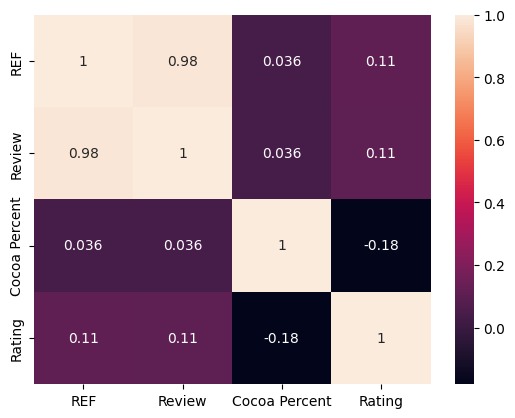

In [22]:
# поиск корелляции числовых признаков (тепловая карта):

sns.heatmap(data.corr(), annot=True, fmt='.2g', xticklabels=True, yticklabels=True)

Выводы:

- признаки REF и Review имеют практически полную корреляцию
- отсутствуют признаки, сильно коррелярующие с целевой переменной

In [23]:
data.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72.0,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72.0,Switzerland,3.50,Unknown,Venezuela
2,Dark Forest,Tanzania,1554,2015,70.0,U.S.A.,3.00,Unknown,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72.0,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75.0,France,3.50,Criollo,Indonesia


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1252 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1252 non-null   object 
 1   Specific Bean Origin  1252 non-null   object 
 2   REF                   1252 non-null   int64  
 3   Review                1252 non-null   int64  
 4   Cocoa Percent         1252 non-null   float64
 5   Company Location      1252 non-null   object 
 6   Rating                1252 non-null   float64
 7   Bean Type             1252 non-null   object 
 8   Broad Bean Origin     1251 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 97.8+ KB


# 3. Data preparation

## 3.1. Преобразование категориальных переменных

In [25]:
# будем использовать TargetEncoder
# enc = TargetEncoder(cols=cat_feats)
# enc.fit(data)
# data_enc = enc.transform(data)

Преобразование будет выполнено позднее в рамках пайпланов

## 3.2. Заполнение пропусков

In [26]:
# с учетом малого количества пропусков (2 шт.), можно просто удалить соответствующие записи
data = data.dropna()
len(data)

1251

## 3.3. Feature engineering - добавление новых признаков

<Axes: xlabel='Cocoa Percent', ylabel='Rating'>

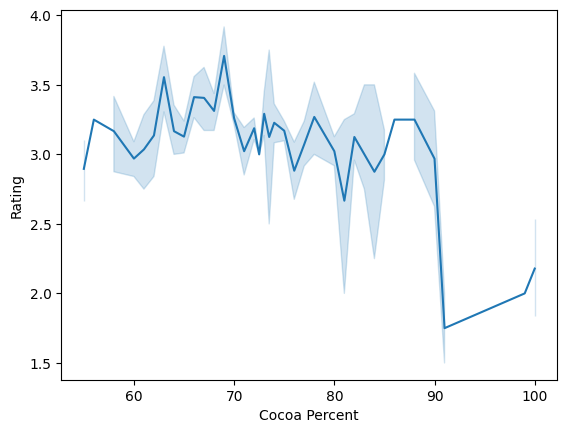

In [27]:
# посмотрим, какая зависимость рейтинга от содержания какоао

sns.lineplot(x='Cocoa Percent', y='Rating', data=data)

Выводы:
- для шоколада с содержанием какао выше ~90% - резкое падение рейтинга
- также низкий рейтинг у шоколада с содержанием какао ниже ~62%

In [28]:
# добавим категориальный признак в зависимости от доли содержания какао

def cocoa_content(percent):
    if percent <= 62:
        return 'low'
    elif percent <= 90:
        return 'moderate'
    else:
        return 'high'

data['Cocoa Content'] = data['Cocoa Percent'].apply(cocoa_content)

data['Cocoa Content'].value_counts()

moderate    1164
low           70
high          17
Name: Cocoa Content, dtype: int64

In [29]:
# добавим категориальный признак - континент расположения фабрики

Europe1 = ['France', 'Denmark', 'Scotland', 'Wales', 'Czech Republic', 'Finland', 'Ireland', 'Portugal', 'Netherlands', 'Poland', 'Amsterdam', 'Sweden', 'U.K.', 'Italy', 'Belgium', 'Switzerland', 'Germany', 'Austria', 'Spain', 'Hungary', 'Iceland', 'Lithuania']
Asia1 = ['Japan', 'Vietnam', 'Israel', 'South Korea', 'Singapore', 'India', 'Philippines', 'Russia']
North_America1 = ['U.S.A.', 'Canada', 'Martinique', 'Niacragua', 'Guatemala', 'St. Lucia', 'Puerto Rico', 'Mexico', 'Costa Rica', 'Honduras', 'Nicaragua', 'Domincan Republic', 'Grenada']
South_America1 = ['Ecuador', 'Eucador', 'Colombia', 'Suriname', 'Bolivia', 'Venezuela', 'Chile', 'Peru', 'Brazil', 'Argentina']
Africa1 = ['Madagascar', 'Sao Tome', 'South Africa', 'Ghana', 'Madagascar']
Oceania1 = ['Australia', 'New Zealand', 'Fiji', 'Papua New Guinea']

def continents(country):
    if country in Asia1:
        return 'Asia'
    if country in Africa1:
        return 'Africa'
    if country in North_America1:
        return 'N. America'
    if country in South_America1:
        return 'S. America'
    if country in Europe1:
        return 'Europe'
    if country in Oceania1:
        return 'Oceania'
    else:
        return 'N. America'

data['Company Continent'] = data['Company Location'].apply(continents)

data['Company Continent'].value_counts()

N. America    644
Europe        403
S. America    106
Oceania        48
Asia           31
Africa         19
Name: Company Continent, dtype: int64

In [30]:
bean_origins = list(data.groupby('Broad Bean Origin')['Broad Bean Origin'].count().index)
bean_origins

['Australia',
 'Belize',
 'Bolivia',
 'Brazil',
 'Carribean',
 'Carribean(DR/Jam/Tri)',
 'Central and S. America',
 'Colombia',
 'Colombia, Ecuador',
 'Congo',
 'Cost Rica, Ven',
 'Costa Rica',
 'Cuba',
 'DR, Ecuador, Peru',
 'Dom. Rep., Madagascar',
 'Domincan Republic',
 'Dominican Rep., Bali',
 'Dominican Republic',
 'Ecuador',
 'El Salvador',
 'Fiji',
 'Gabon',
 'Ghana',
 'Ghana, Domin. Rep',
 'Grenada',
 'Guat., D.R., Peru, Mad., PNG',
 'Guatemala',
 'Haiti',
 'Hawaii',
 'Honduras',
 'India',
 'Indonesia',
 'Indonesia, Ghana',
 'Ivory Coast',
 'Jamaica',
 'Liberia',
 'Mad., Java, PNG',
 'Madagascar',
 'Madagascar & Ecuador',
 'Malaysia',
 'Mexico',
 'Nicaragua',
 'Nigeria',
 'PNG, Vanuatu, Mad',
 'Panama',
 'Papua New Guinea',
 'Peru',
 'Peru, Belize',
 'Peru, Dom. Rep',
 'Peru, Ecuador, Venezuela',
 'Peru, Mad., Dom. Rep.',
 'Peru, Madagascar',
 'Philippines',
 'Principe',
 'Puerto Rico',
 'Samoa',
 'Sao Tome',
 'Sao Tome & Principe',
 'Solomon Islands',
 'South America',
 'South

In [31]:
# опять видим "скрытые" пропуски
# проверим их наличие в других признаках

for col in data.columns:
    print(col, len(data[data[col] == nnan]))

Company 0
Specific Bean Origin 0
REF 0
Review 0
Cocoa Percent 0
Company Location 0
Rating 0
Bean Type 0
Broad Bean Origin 55
Cocoa Content 0
Company Continent 0


In [32]:
# в других столбцах таких скрытых пропусков нет
# заменим их на "Unknown" в признаке "Broad Bean Origin"

data['Broad Bean Origin'] = data['Broad Bean Origin'].replace(nnan, 'Unknown')

data['Broad Bean Origin'].value_counts()

Venezuela                  144
Ecuador                    142
Peru                       122
Dominican Republic         104
Madagascar                 103
                          ... 
Ven., Indonesia, Ecuad.      1
Ven., Trinidad, Mad.         1
Peru, Dom. Rep               1
Cost Rica, Ven               1
Venezuela, Carribean         1
Name: Broad Bean Origin, Length: 84, dtype: int64

In [33]:
# вернемся к причесыванию признака Broad Bean Origin - вручную делать это очень долго
# попробуем добавить признак континента - как по компаниям

Europe = []
Asia = ['India', 'Vietnam', 'Malaysia', 'Indonesia', 'Sri Lanka']
North_America = ['Cost Rica, Ven', 'Costa Rica', 'Domincan Republic', 'Dominican Republic', 'Nicaragua', 'Grenada', 'Hawaii', 'Puerto Rico', 'Belize', 'Philippines', 'Panama', 'Cuba', 'Mexico', 'Guatemala', 'Haiti', 'Honduras']
South_America = ['Bolivia', 'Brazil', 'Colombia', 'Colombia, Ecuador', 'DR, Ecuador, Peru', 'Peru', 'Peru, Dom. Rep', 'Peru, Ecuador, Venezuela', 'South America', 'Venezuela', 'Ven, Bolivia, D.R.', 'Tobago', 'Trinidad', 'Trinidad, Ecuador', 'Suriname', 'Jamaica', 'Central and S. America', 'El Salvador', 'Ven.,Ecu.,Peru,Nic.', 'Ecuador', 'Carribean',  'Carribean(DR/Jam/Tri)', 'Venezuela, Carribean', 'St. Lucia']
Africa = ['Congo', 'Liberia', 'West Africa', 'Nigeria', 'Uganda', 'Ivory Coast', 'Sao Tome', 'Sao Tome & Principe', 'Tanzania', 'Gabon', 'Ghana', 'Madagascar', 'Togo']
Oceania = ['Australia', 'Fiji', 'Vanuatu', 'Solomon Islands', 'Samoa', 'Papua New Guinea']
Other = ['Dom. Rep., Madagascar', 'Peru, Madagascar', 'Ven., Indonesia, Ecuad.', 'Venez,Africa,Brasil,Peru,Mex', 'Venezuela, Dom. Rep.', 'Venezuela, Ghana', 'Ven., Trinidad, Mad.', 'Peru, Mad., Dom. Rep.', 'Ghana, Domin. Rep', 'Mad., Java, PNG', 'Indonesia, Ghana', 'South America, Africa', 'Madagascar & Ecuador', 'Venezuela, Java', 'Guat., D.R., Peru, Mad., PNG', 'Peru, Belize', 'Dominican Rep., Bali', 'PNG, Vanuatu, Mad', 'Principe']

def continents2(origin):
    if origin in Asia:
        return 'Asia'
    if origin in Africa:
        return 'Africa'
    if origin in North_America:
        return 'N. America'
    if origin in South_America:
        return 'S. America'
    if origin in Europe:
        return 'Europe'
    if origin in Oceania:
        return 'Oceania'
    if origin in Other:
        return 'Other'
    else:
        return 'Other'

data['Broad Bean Origin Continent'] = data['Broad Bean Origin'].apply(continents2)

data['Broad Bean Origin Continent'].value_counts()

S. America    585
N. America    316
Africa        189
Other          75
Asia           46
Oceania        40
Name: Broad Bean Origin Continent, dtype: int64

Очень много записей оказалось в категории "Other" (в т.ч. те, где несколько континентов сразу). Скорее всего, признак окажется неэффективным.

In [34]:
data.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin,Cocoa Content,Company Continent,Broad Bean Origin Continent
0,Willie's Cacao,Rio Caribe,457,2009,72.0,U.K.,3.25,Trinitario,Venezuela,moderate,Europe,S. America
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72.0,Switzerland,3.50,Unknown,Venezuela,moderate,Europe,S. America
2,Dark Forest,Tanzania,1554,2015,70.0,U.S.A.,3.00,Unknown,Tanzania,moderate,N. America,Africa
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72.0,U.S.A.,3.00,Trinitario,Dominican Republic,moderate,N. America,N. America
4,Pralus,"Java, Indonesie",32,2006,75.0,France,3.50,Criollo,Indonesia,moderate,Europe,Asia


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1251 entries, 0 to 1254
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Company                      1251 non-null   object 
 1   Specific Bean Origin         1251 non-null   object 
 2   REF                          1251 non-null   int64  
 3   Review                       1251 non-null   int64  
 4   Cocoa Percent                1251 non-null   float64
 5   Company Location             1251 non-null   object 
 6   Rating                       1251 non-null   float64
 7   Bean Type                    1251 non-null   object 
 8   Broad Bean Origin            1251 non-null   object 
 9   Cocoa Content                1251 non-null   object 
 10  Company Continent            1251 non-null   object 
 11  Broad Bean Origin Continent  1251 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 127.1+ KB


In [36]:
num_feats = ['REF', 'Review', 'Cocoa Percent']
cat_feats = ['Company', 'Specific Bean Origin', 'Company Location', 'Bean Type', 'Broad Bean Origin', 'Cocoa Content', 'Company Continent', 'Broad Bean Origin Continent']

data[cat_feats] = data[cat_feats].astype('category')

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1251 entries, 0 to 1254
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Company                      1251 non-null   category
 1   Specific Bean Origin         1251 non-null   category
 2   REF                          1251 non-null   int64   
 3   Review                       1251 non-null   int64   
 4   Cocoa Percent                1251 non-null   float64 
 5   Company Location             1251 non-null   category
 6   Rating                       1251 non-null   float64 
 7   Bean Type                    1251 non-null   category
 8   Broad Bean Origin            1251 non-null   category
 9   Cocoa Content                1251 non-null   category
 10  Company Continent            1251 non-null   category
 11  Broad Bean Origin Continent  1251 non-null   category
dtypes: category(8), float64(2), int64(2)
memory usage: 101.3 KB


## 3.4. Итоговый отбор признаков

### 3.4.1. Корреляционный анализ

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1251 entries, 0 to 1254
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Company                      1251 non-null   category
 1   Specific Bean Origin         1251 non-null   category
 2   REF                          1251 non-null   int64   
 3   Review                       1251 non-null   int64   
 4   Cocoa Percent                1251 non-null   float64 
 5   Company Location             1251 non-null   category
 6   Rating                       1251 non-null   float64 
 7   Bean Type                    1251 non-null   category
 8   Broad Bean Origin            1251 non-null   category
 9   Cocoa Content                1251 non-null   category
 10  Company Continent            1251 non-null   category
 11  Broad Bean Origin Continent  1251 non-null   category
dtypes: category(8), float64(2), int64(2)
memory usage: 101.3 KB


<Axes: >

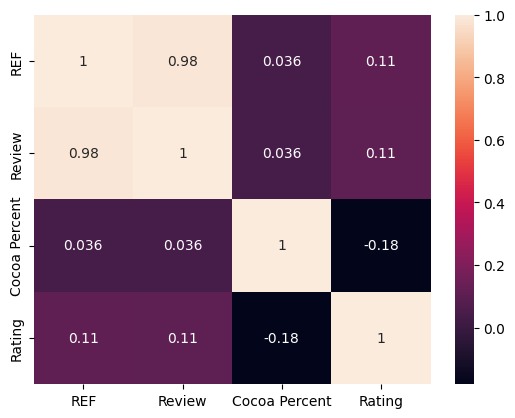

In [39]:
# поиск корелляции числовых признаков (тепловая карта):

sns.heatmap(data.corr(), annot=True, fmt='.2g', xticklabels=True, yticklabels=True)

Вывод:
- нецелесообразно использование признака Review (высокая корреляция с признаком REF)

In [40]:
XC = data.apply(
    lambda x: x.astype('category') if x.dtype == 'object' else x)

cramersv = am.CramersV(XC)
cramersv.fit()

,Company,Specific Bean Origin,Company Location,Bean Type,Broad Bean Origin,Cocoa Content,Company Continent,Broad Bean Origin Continent
Company,1.000000,0.771150,0.999651,0.615572,0.603567,0.584871,0.997310,0.661990
Specific Bean Origin,0.771150,1.000000,0.808158,0.907902,0.983537,0.829473,0.835077,0.995171
Company Location,0.999651,0.808158,1.000000,0.289720,0.381826,0.261006,1.000000,0.409911
Bean Type,0.615572,0.907902,0.289720,1.000000,0.387667,0.163420,0.273708,0.379795
Broad Bean Origin,0.603567,0.983537,0.381826,0.387667,1.000000,0.319807,0.445362,1.000000
Cocoa Content,0.584871,0.829473,0.261006,0.163420,0.319807,1.000000,0.124286,0.136518
Company Continent,0.997310,0.835077,1.000000,0.273708,0.445362,0.124286,1.000000,0.309137
Broad Bean Origin Continent,0.661990,0.995171,0.409911,0.379795,1.000000,0.136518,0.309137,1.000000


Вывод - нецелесообразно использование признаков:
- Company Location (высокая корреляция с Company и Company Continent)
- Company (высокая корреляция с Company Continent)
- Specific Bean Origin (высокая корреляция с Broad Bean Origin, Broad Bean Origin Continent)
- Broad Bean Origin (высокая корреляция с Broad Bean Origin Continent)

### 3.4.2. Feature importance (RF)

In [41]:
num_feats = ['REF', 'Review', 'Cocoa Percent']
cat_feats = ['Company', 'Specific Bean Origin', 'Company Location', 'Bean Type', 'Broad Bean Origin', 'Cocoa Content', 'Company Continent', 'Broad Bean Origin Continent']

In [42]:
data_pipe_fi = Pipeline([
   ('encoder_', TargetEncoder(cols=cat_feats))
])

In [43]:
X_fi = data.drop(['Rating'], axis=1)
Y_fi = data['Rating']

names = X_fi.columns

X_fi_enc = data_pipe_fi.fit_transform(X_fi, Y_fi)

model = RandomForestRegressor()
model.fit(X_fi_enc, Y_fi)

dic = {}

for i in range(len(names)):
    dic[names[i]] = model.feature_importances_[i]

print('Важность признаков в модели RandimForest (по убыванию):')

for k, v in sorted(dic.items(), key=lambda x: x[1], reverse=True):
    print(f'{k}:  {v:4f}')

Важность признаков в модели RandimForest (по убыванию):
Specific Bean Origin:  0.628219
Company:  0.191234
REF:  0.046561
Cocoa Percent:  0.043625
Broad Bean Origin:  0.020999
Bean Type:  0.016371
Company Location:  0.016360
Review:  0.013805
Cocoa Content:  0.008740
Company Continent:  0.007539
Broad Bean Origin Continent:  0.006547


Выводы абсолютно иные!
- Наименее важными признаками оказались добавленные в разделе Feature Engineering!
- Наиболее важными - предложенные к удалению в рамках корреляционного анализа!

### 3.4.3. Recursive Feature Elimination

In [44]:
# определяем оптимальное количество признаков

estimator = LinearRegression()
pipe_rfe = make_pipeline(RFE(estimator, step=1),
                         KNeighborsRegressor())

parameters = {'rfe__n_features_to_select': range(5, 10)}

grid_rfe = GridSearchCV(pipe_rfe, param_grid=parameters, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
grid_rfe.fit(StandardScaler().fit_transform(X_fi_enc), Y_fi)

print(f'Best parameters:  {grid_rfe.best_params_}')

Best parameters:  {'rfe__n_features_to_select': 5}


In [45]:
# Отбор признаков

selector = RFE(estimator, n_features_to_select=grid_rfe.best_params_['rfe__n_features_to_select'], step=1)
selector = selector.fit(X_fi_enc, Y_fi)
selector.get_support()

array([ True,  True, False, False, False,  True, False, False,  True,
        True, False])

Выводы - рекомендованы к исключению признаки:
- REF
- Review
- Cocoa Percent
- Bean Type
- Broad Bean Origin  
- Broad Bean Origin Continent

### 3.4.4. Sequential Feature Selection

In [46]:
knn = KNeighborsRegressor()
sfs = SequentialFeatureSelector(knn, n_features_to_select=grid_rfe.best_params_['rfe__n_features_to_select'])
sfs.fit(X_fi_enc, Y_fi)
sfs.get_support()

array([ True,  True, False, False, False, False, False,  True,  True,
       False,  True])

Выводы - рекомендованы к исключению признаки:
- Review
- Cocoa Percent
- Company Location
- Bean Type
- Broad Bean Origin
- Company Continent

### 3.4.5. Итоговое решение по отбору признаков

- Различные подходы к отбору признаков дали совершенно разные результаты
- По итогам (с учетом предварительно проведенной оценки эффекта на метрики) принимается решение об удалении следующих признаков:
-- Review
-- Bean Type
-- Brod Bean Origin Continent

In [47]:
data.columns

Index(['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
       'Company Location', 'Rating', 'Bean Type', 'Broad Bean Origin',
       'Cocoa Content', 'Company Continent', 'Broad Bean Origin Continent'],
      dtype='object')

In [48]:
num_feats = ['REF', 'Cocoa Percent']
cat_feats = ['Company', 'Specific Bean Origin', 'Company Location', 'Broad Bean Origin', 'Cocoa Content', 'Company Continent']
full_feats = num_feats + cat_feats + ['Rating']
full_feats

['REF',
 'Cocoa Percent',
 'Company',
 'Specific Bean Origin',
 'Company Location',
 'Broad Bean Origin',
 'Cocoa Content',
 'Company Continent',
 'Rating']

## 3.5. Сборка финального датасета для моделирования

In [49]:
data_elim = data[full_feats]

In [50]:
X = data_elim.drop(['Rating'], axis=1)
y = data_elim['Rating']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((938, 8), (313, 8), (938,), (313,))

In [52]:
X_train.head()

,REF,Cocoa Percent,Company,Specific Bean Origin,Company Location,Broad Bean Origin,Cocoa Content,Company Continent
168,899,70.0,Friis Holm (Bonnat),"Red Mayan, Xoco",Denmark,Honduras,moderate,Europe
593,1646,80.0,Georgia Ramon,Conacado Coop,Germany,Domincan Republic,moderate,Europe
1154,256,70.0,Black Mountain,La Red,U.S.A.,Dominican Republic,moderate,N. America
441,404,72.0,Cemoi,Equateur,France,Ecuador,moderate,Europe
155,1578,70.0,Zak's,"Dominican Republic, Batch D2",U.S.A.,Domincan Republic,moderate,N. America


# 4. Первичное обучение моделей

## 4.1. Первичное обучение и выбор моделей

In [53]:
p1 = Pipeline([
    ('encoder_', OrdinalEncoder(cols=cat_feats)),
    ('scaler_', StandardScaler()),
    ('model', LinearRegression())
])

In [54]:
p1.fit(X_train, y_train)
pred1 = p1.predict(X_test)
print(r2_score(y_test, pred1))

0.034069417544189795


In [55]:
p2 = Pipeline([
    ('encoder_', TargetEncoder(cols=cat_feats, smoothing=1)),
    ('features', PolynomialFeatures()),
    ('model', xgb.XGBRegressor())
])

In [56]:
p2.fit(X_train, y_train)
pred2 = p2.predict(X_test)
print(r2_score(y_test, pred2))

0.10039712752056684


In [57]:
p3 = Pipeline([
    ('encoder_', TargetEncoder(cols=cat_feats, smoothing=20)),
    ('scaler_', MinMaxScaler()),
    ('model', KNeighborsRegressor())
])

In [58]:
p3.fit(X_train, y_train)
pred3 = p3.predict(X_test)
print(r2_score(y_test, pred3))

0.1408117627327109


In [59]:
p4 = Pipeline([
    ('encoder_', TargetEncoder(cols=cat_feats, smoothing=20)),
    ('scaler_', StandardScaler()),
    ('model', xgb.XGBRegressor())
])

In [60]:
p4.fit(X_train, y_train)
pred4 = p4.predict(X_test)
print(r2_score(y_test, pred4))

-0.019828440744140696


In [77]:
p5 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_feats, smoothing=1)),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

In [78]:
p5.fit(X_train, y_train)
pred5 = p5.predict(X_test)
print(r2_score(y_test, pred5))

0.20670568806402045


In [79]:
p6 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_feats, smoothing=1)),
    ('features_', PolynomialFeatures()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

In [80]:
p6.fit(X_train, y_train)
pred6 = p6.predict(X_test)
print(r2_score(y_test, pred6))

0.20661137861763512


In [65]:
p7 = Pipeline([
    ('model_', CatBoostRegressor(cat_features=cat_feats, silent=True))
    ])

In [66]:
p7.fit(X_train, y_train)
pred7 = p7.predict(X_test)
print(r2_score(y_test, pred7))
print(cross_val_score(CatBoostRegressor(cat_features=cat_feats, silent=True), X, y, scoring='r2', cv=4).mean())

0.18949649074354857
0.19291278796849942


In [67]:
p8 = Pipeline([
    ('encoder_', TargetEncoder(cols=cat_feats, smoothing=1)),
    ('model_', xgb.XGBRegressor())
    ])

In [68]:
p8.fit(X_train, y_train)
pred8 = p8.predict(X_test)
print(r2_score(y_test, pred8))

0.056220036778989346


In [69]:
p9 = Pipeline([
    ('encoder_', OrdinalEncoder(cols=cat_feats)),
    ('model_', GradientBoostingRegressor())
    ])

In [70]:
p9.fit(X_train, y_train)
pred9 = p9.predict(X_test)
print(r2_score(y_test, pred9))

0.0017268274189299326


=> лучшие результаты в рамках первичной подброки модели дают CatBoost и RandomForest

## 4.2. Тюнинг моделей

Попробуем найти оптимальные параметры для модели CatBoostRegressor

In [ ]:
# подбор параметров

def objective(trial):
    model = CatBoostRegressor(
        cat_features=cat_feats,
        iterations=500,
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
        depth=trial.suggest_int('depth', 3, 10),
        subsample = trial.suggest_float('subsample', 0.05, 1.0),
        grow_policy = trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),
        border_count = trial.suggest_int('border_count', 5, 100),
        l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 2, 10),
        colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.05, 1.0),
        min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 100),
        verbose=0
    ).fit(X, y)
    score = cross_val_score(model, X, y, scoring='r2', cv=4).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2023-10-02 09:01:27,285] A new study created in memory with name: no-name-002fb432-3126-4327-96d7-5cdd31a3ef6e
[I 2023-10-02 09:01:30,736] Trial 0 finished with value: 0.03090913757246247 and parameters: {'learning_rate': 0.0004628271587516738, 'depth': 5, 'subsample': 0.2716991983682848, 'grow_policy': 'Depthwise', 'border_count': 95, 'l2_leaf_reg': 7, 'colsample_bylevel': 0.47933997212418533, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.03090913757246247.
[I 2023-10-02 09:01:33,864] Trial 1 finished with value: 0.00032567498588181865 and parameters: {'learning_rate': 6.0574804195105575e-05, 'depth': 7, 'subsample': 0.6146546470934451, 'grow_policy': 'Depthwise', 'border_count': 84, 'l2_leaf_reg': 10, 'colsample_bylevel': 0.21430591956771888, 'min_data_in_leaf': 49}. Best is trial 0 with value: 0.03090913757246247.
[I 2023-10-02 09:02:07,267] Trial 2 finished with value: -0.0006495215007420729 and parameters: {'learning_rate': 2.6873095516243913e-05, 'depth': 10, 'subsampl

In [ ]:
# лучшие подобранные параметры (чтобы не перезапускать длительный подбор):

# study.best_params

# {'learning_rate': 0.006626323748543755,
#  'depth': 10,
#  'subsample': 0.9893623908317491,
#  'grow_policy': 'Depthwise',
#  'border_count': 17,
#  'l2_leaf_reg': 2,
#  'colsample_bylevel': 0.7121667465028819,
#  'min_data_in_leaf': 10}

In [81]:
cb_best_params = {'learning_rate': 0.006626323748543755,
                  'depth': 10,
                  'subsample': 0.9893623908317491,
                  'grow_policy': 'Depthwise',
                  'border_count': 17,
                  'l2_leaf_reg': 2,
                  'colsample_bylevel': 0.7121667465028819,
                  'min_data_in_leaf': 10}

In [82]:
# обучаем модель на всем тренировочном файле
model1 = CatBoostRegressor(**cb_best_params, cat_features=cat_feats, silent=True)
model1.fit(X, y)

# 5. Развертывание

In [83]:
# загрузка данных для формирования предсказаний в рамках соревнования
test_df = pd.read_csv(TEST)
test_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Ohiyo,"San Juan Estate, Gran Couva",1594,2015,70%,U.S.A.,Trinitario,Trinidad
1,Blanxart,Organic Dark,322,2009,72%,Spain,,
2,Brazen,Maya Mountain,1518,2015,80%,U.S.A.,Trinitario,Belize
3,Patric,Madagascar,439,2009,67%,U.S.A.,Trinitario,Madagascar
4,Potomac,"Upala, Batch 12",607,2010,82%,U.S.A.,Matina,Costa Rica


In [84]:
# проверка наличия пропусков

test_df.isnull().sum()

Company                 0
Specific Bean Origin    0
REF                     0
Review                  0
Cocoa Percent           0
Company Location        0
Bean Type               0
Broad Bean Origin       0
dtype: int64

In [85]:
# проведение предварительных преобразований, аналогичных выполненным ранее на обучающем файле

test_df['Cocoa Percent'] = test_df['Cocoa Percent'].apply(lambda x: float(x[:-1]))
test_df['Cocoa Content'] = test_df['Cocoa Percent'].apply(cocoa_content)
test_df['Company Continent'] = test_df['Company Location'].apply(continents)
test_df['Broad Bean Origin'] = test_df['Broad Bean Origin'].replace(nnan, 'Unknown')
test_df['Broad Bean Origin'] = test_df['Broad Bean Origin'].replace(np.nan, 'Unknown')
test_df = test_df.drop(['Review', 'Bean Type'], axis=1)
test_df[cat_feats] = test_df[cat_feats].astype('category')
test_df.head()

,Company,Specific Bean Origin,REF,Cocoa Percent,Company Location,Broad Bean Origin,Cocoa Content,Company Continent
0,Ohiyo,"San Juan Estate, Gran Couva",1594,70.0,U.S.A.,Trinidad,moderate,N. America
1,Blanxart,Organic Dark,322,72.0,Spain,Unknown,moderate,Europe
2,Brazen,Maya Mountain,1518,80.0,U.S.A.,Belize,moderate,N. America
3,Patric,Madagascar,439,67.0,U.S.A.,Madagascar,moderate,N. America
4,Potomac,"Upala, Batch 12",607,82.0,U.S.A.,Costa Rica,moderate,N. America


In [86]:
test_df['Broad Bean Origin'].fillna('Unknown', inplace=True)

In [88]:
# задаем нужный порядок признаков
test_df = test_df[['REF', 'Cocoa Percent', 'Company', 'Specific Bean Origin', 'Company Location', 'Broad Bean Origin', 'Cocoa Content', 'Company Continent']]

In [89]:
cat_feats

['Company',
 'Specific Bean Origin',
 'Company Location',
 'Broad Bean Origin',
 'Cocoa Content',
 'Company Continent']

In [90]:
# CatBoost

pred1 = model1.predict(test_df)

test_df['id'] = np.arange(len(test_df))
test_df['Rating'] = pred1

test_df[['id','Rating']].to_csv("whyayeman_submission_cb.csv", index=False)

- SUBMISSION SCORED: **0.21264**
- COMPETITION RANK: **3 / 38**

*(as of Oct 02 2023, https://www.kaggle.com/competitions/practical-ml-chocolate/leaderboard)*